In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

In [48]:
##############################################
## Load, partition, and resize CIFAR10 Data ##
##############################################
def loadData():
    import pickle

    # unpickle the binary files
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    labels = ['airplane',  # index 0
          'automobile',  # index 1
          'bird',  # index 2 
          'cat',  # index 3 
          'deer',  # index 4
          'dog',  # index 5
          'frog',  # index 6 
          'horse',  # index 7 
          'ship',  # index 8 
          'truck']  # index 9
    
    # paths to each batch of data
    batch1 = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/data_batch_5")
    meta = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/batches.meta")
    test = unpickle("/scratch/gpfs/eysu/src_data/cifar-10-batches-py/test_batch")

    # separate labels and image data from each batch
    y_train1 = batch1[b'labels']
    x_train1 = batch1[b'data']
    y_train2 = batch2[b'labels']
    x_train2 = batch2[b'data']
    y_train3 = batch3[b'labels']
    x_train3 = batch3[b'data']
    y_train4 = batch4[b'labels']
    x_train4 = batch4[b'data']
    y_train5 = batch5[b'labels']
    x_train5 = batch5[b'data']

    # concatenate into big training and testing arrays
    y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5))
    x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4, x_train5), axis=0)
    
    # shuffle the training data identically to before
    def shuffle_in_unison(x, y, permutation):
        assert x.shape[0] == y.shape[0]
        shuffled_x = np.empty(x.shape, dtype=x.dtype)
        shuffled_y = np.empty(y.shape, dtype=y.dtype)
        for old_index, new_index in enumerate(permutation):
            shuffled_x[new_index] = x[old_index]
            shuffled_y[new_index] = y[old_index]

        return shuffled_x, shuffled_y

    permutation = np.loadtxt('/scratch/gpfs/eysu/src_data/cifar-10-batches-py/permutation.csv', delimiter=',').astype(np.int64)

    x_train, y_train = shuffle_in_unison(x_train, y_train, permutation)

    y_test = test[b'labels']
    x_test = test[b'data']
    
    # Further break training data into train / validation sets 
    # put 5000 into validation set and keep remaining 45,000 for train
    (x_train, x_valid) = x_train[5000:], x_train[:5000] 
    (y_train, y_valid) = y_train[5000:], y_train[:5000]

    # reshape data to match dimensions of cifar10.load_data
    x_train = x_train.reshape(45000, 3, 32, 32)
    x_train = x_train.transpose(0, 2, 3, 1)
    x_train = x_train.astype('float32')
    x_train /= 255

    # y_train = tf.keras.utils.to_categorical(y_train, 10)

    x_valid = x_valid.reshape(5000, 3, 32, 32)
    x_valid = x_valid.transpose(0, 2, 3, 1)
    x_valid = x_valid.astype('float32')
    x_valid /= 255

    x_test = x_test.reshape(10000, 3, 32, 32)
    x_test = x_test.transpose(0, 2, 3, 1)
    x_test = x_test.astype('float32')
    x_test /= 255
    
    y_train = np.array(y_train)
    y_valid = np.array(y_valid)
    y_test = np.array(y_test)
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

x_train, x_valid, x_test, y_train, y_valid, y_test = loadData()

In [2]:
# load in the soft probabilities
soft = np.load('/scratch/gpfs/eysu/src_data/cifar-10h/data/cifar10h-probs.npy')

# this matrix corresponds to the soft classification vectors of each test image in CIFAR10
# print(soft.shape)
# (10000, 10)


In [16]:
###########################################################################################
## Read prediction softmax layer activations for all test set images, and all iterations ##
###########################################################################################

MAX_ITER = 25

# Build arrays of dimensions: N training images X L labels X P iterations
y_hat_test_arr = np.zeros([10000, 10, MAX_ITER])

for i in range(MAX_ITER):
    if i == 0:
        y_hat_test_name = 'y_hat_test_seed'
    else:
        y_hat_test_name = 'y_hat_test_' + 'iter' + str(i)
        
    # Load test set softmax outputs 
    yhte = np.load('/scratch/gpfs/eysu/CIFAR10_results/og_training/' + y_hat_test_name + '.npy')

    # The first time through, use binary weight vectors to save correct class array
#     if i == 0:
#         true_class_tr = np.nonzero(yhte)[1]
        
    y_hat_test_arr[:, :, i] = yhte
    
# final_predictions = np.argmax(y_hat_train_arr[:,:, 24], axis=1)

print(y_hat_test_arr.shape)
# (10000, 10, 25)

(10000, 10, 25)


In [5]:
# print(y_hat_test_arr[0, :, 0])
# print(soft[0])
# print(y_hat_test_arr[0, :, 0] - soft[0])
diffs = y_hat_test_arr - np.expand_dims(soft, axis=2)
# print(diffs[0, :, 0])
# print(diffs.shape)

In [6]:
norm_diffs = np.linalg.norm(diffs, axis=1)
print(norm_diffs.shape)

(10000, 25)


In [28]:
print(y_test)
print(true_class_tr)

[3 8 8 ... 5 1 7]
[0 1 2 ... 7 8 9]


(25,)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)


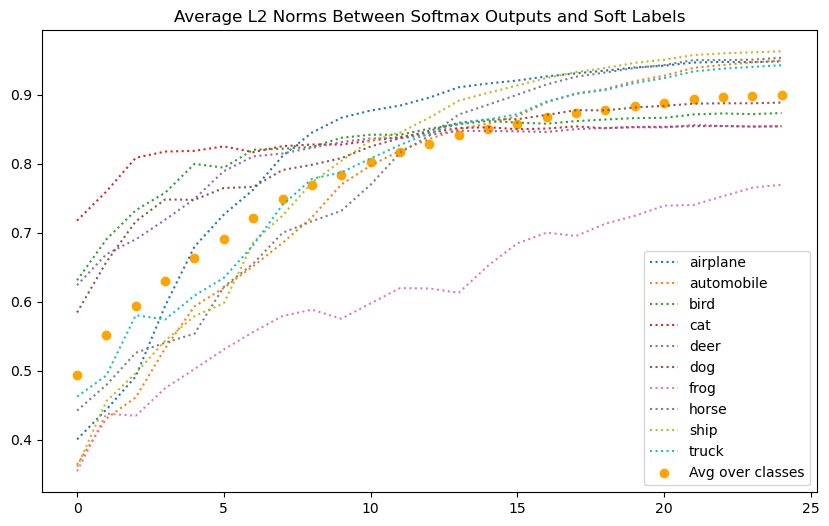

In [46]:
labels = ['airplane',  # index 0
      'automobile',  # index 1
      'bird',  # index 2 
      'cat',  # index 3 
      'deer',  # index 4
      'dog',  # index 5
      'frog',  # index 6 
      'horse',  # index 7 
      'ship',  # index 8 
      'truck']  # index 9
norm_diff_iters = np.mean(norm_diffs, axis=0)
print(norm_diff_iters.shape)

plt.figure(figsize=(10,6))
class_avgs = np.zeros((10,25))
for i in range(10):
    class_data = norm_diffs[y_test == i]
    print(class_data.shape)
    class_avgs[i,:] = np.mean(class_data, axis=0)

    plt.plot(x, class_avgs[i], label = labels[i], linestyle = "dotted")

plt.scatter(x, norm_diffs_iters, c = "orange", label = "Avg over classes")
plt.legend()
plt.title("Average L2 Norms Between Softmax Outputs and Soft Labels")
plt.show()


(25,)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)


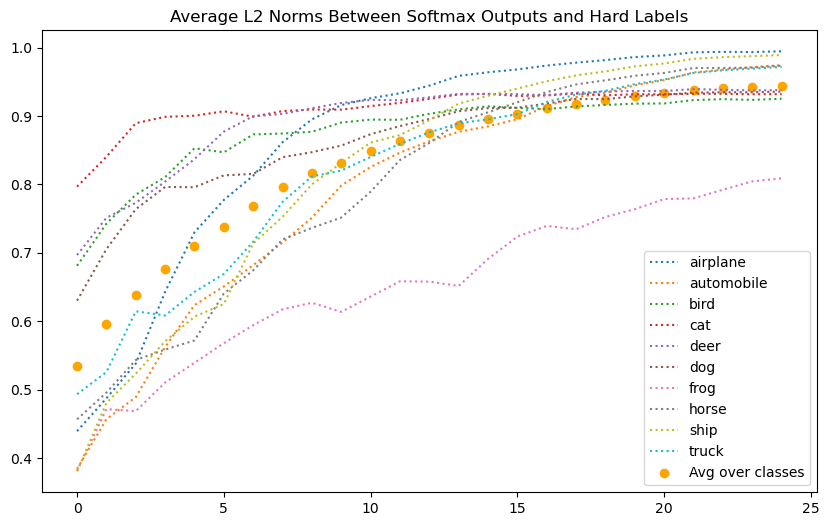

In [50]:
y_test_10 = keras.utils.to_categorical(y_test, 10)
hard_labels = np.expand_dims(y_test_10, axis=2)
hard_diffs = y_hat_test_arr - hard_labels
hard_norms = np.linalg.norm(hard_diffs, axis=1)

labels = ['airplane',  # index 0
      'automobile',  # index 1
      'bird',  # index 2 
      'cat',  # index 3 
      'deer',  # index 4
      'dog',  # index 5
      'frog',  # index 6 
      'horse',  # index 7 
      'ship',  # index 8 
      'truck']  # index 9

hard_norms_iters = np.mean(hard_norms, axis=0)
print(hard_norms_iters.shape)

plt.figure(figsize=(10,6))
class_avgs = np.zeros((10,25))
for i in range(10):
    class_data = hard_norms[y_test == i]
    print(class_data.shape)
    class_avgs[i,:] = np.mean(class_data, axis=0)

    plt.plot(x, class_avgs[i], label = labels[i], linestyle = "dotted")

plt.scatter(x, hard_norms_iters, c = "orange", label = "Avg over classes")
plt.legend()
plt.title("Average L2 Norms Between Softmax Outputs and Hard Labels")
plt.show()


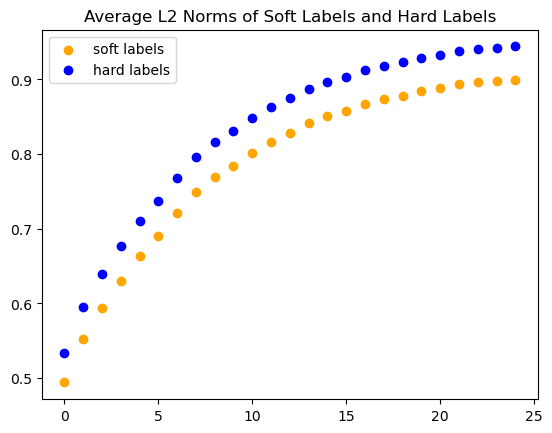

In [51]:
plt.scatter(x, norm_diffs_iters, c = "orange", label = "soft labels")
plt.scatter(x, hard_norms_iters, c = "blue", label = "hard labels")
plt.legend()
plt.title("Average L2 Norms of Soft Labels and Hard Labels")
plt.show()


(10000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)


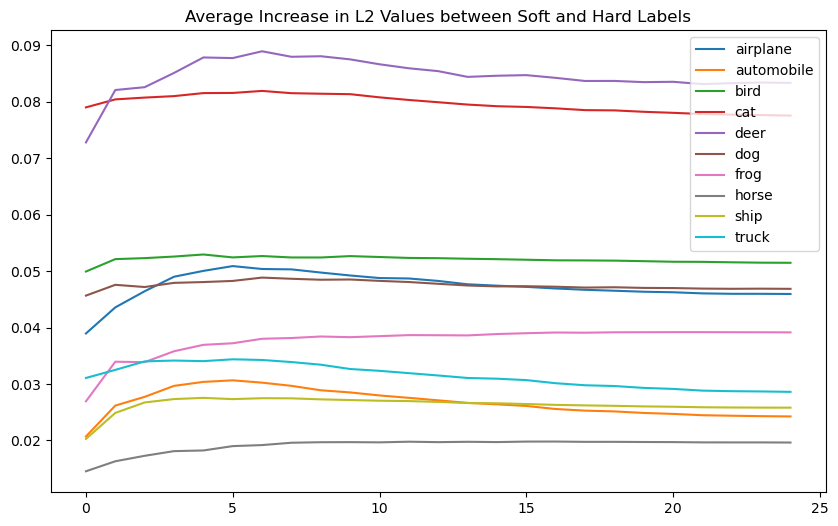

In [61]:
# plot how the differneces in L2 betwen soft and hard labels

better = hard_norms - norm_diffs
print(better.shape)
plt.figure(figsize=(10,6))
better_avgs = np.zeros((10, 25))
for i in range(10):
    class_data = better[y_test == i]
    print(class_data.shape)
    better_avgs[i,:] = np.mean(class_data, axis=0)
    plt.plot(x, better_avgs[i], label = labels[i])

plt.legend()
plt.title("Average Increase in L2 Values between Soft and Hard Labels")
plt.show()